# Analysis

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
basegrids = json.load(open("../mazes/mazes_0-11.json", 'r'))
hover_df = pd.DataFrame(json.load(open("./data/hovering-data-trials.json", 'r')))
nav_trials = pd.DataFrame(json.load(open("./data/all-navigation-trials.json", 'r')))

In [3]:
from msdm.domains import GridWorld
from matplotlib.colors import to_rgb
mediumblue = np.array(to_rgb('mediumblue'))
gainsboro = np.array(to_rgb('gainsboro'))

def color_mix(v, alpha=12):
    w = 1/(1 + np.exp(-alpha*(v-.5)))
    return (1-w)*gainsboro + w*mediumblue

def plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=False, number_fontsize=15, number_format="f"):
    fc = {o: color_mix((v - vmin)/(vmax - vmin)) for o, v in values.items()}
    gw = GridWorld(tile_array, absorbing_features=('G', ), initial_features=('S',))
    start = gw.initial_states[0]
    goal = gw.absorbing_states[0]
    gwp = gw.plot(featurecolors=fc, ax=ax, plot_initial_states=False, plot_absorbing_states=False).\
        annotate(start, text="S", fontsize=30, fontfamily="Courier New", weight='bold').\
        annotate(goal, text="G", fontsize=30, fontfamily="Courier New", weight='bold')
    if show_numbers:
        marked = []
        for loc, f in gw.location_features.items():
            if (f in fc) and (f not in marked):
                marked.append(f)
                if number_format == 'f':
                    if 0 < values[f] < 1.0:
                        text = f"{values[f]:.2f}".lstrip("0")
                    else: 
                        text = f"{values[f]:.1f}"
                elif number_format == 'g':
                    text = ("%.2g" % values[f]).replace("-0","-").lstrip("0")
                gwp.annotate(loc, 
                             text=text,
                             fontsize=number_fontsize,
                             weight='bold',
                             color='w' if ((values[f] - vmin)/(vmax - vmin)) > .5 else 'k')
        
    if title:
        gwp.title(f"{title}", fontsize=20)

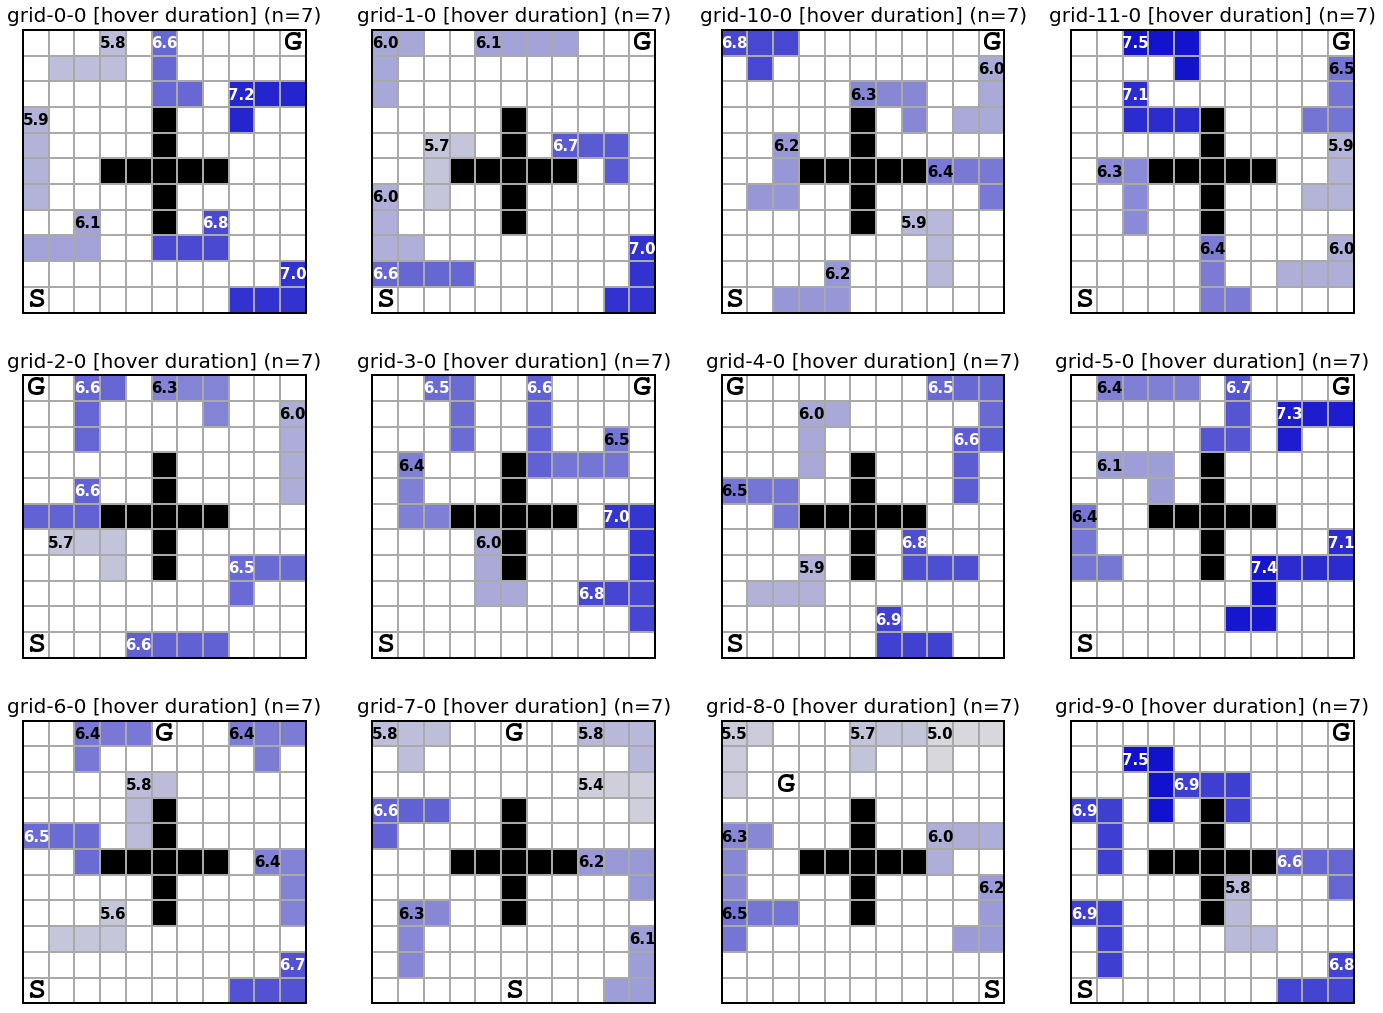

In [4]:
to_plot = hover_df.groupby(['grid', 'obstacle'])['log_hoverduration'].agg(['mean', 'sem', 'count']).reset_index()
nrows = 3
ncols = 4
mul=6
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*mul, nrows*mul))
axes = list(axes.flatten())
mean_loghd = hover_df['log_hoverduration'].mean()
std_loghd = hover_df['log_hoverduration'].std()
vmin = mean_loghd - 2*std_loghd
vmax = mean_loghd + 2*std_loghd
for grid, rows in to_plot.groupby('grid'):
    tile_array = basegrids[grid]
    values = dict(zip([str(o) for o in rows.obstacle.values], rows['mean'].fillna(0).values))
    ax = axes.pop(0)
    title = f"{grid} [hover duration] (n={len(rows)})"
    plot_obstacle_values(tile_array, values, ax, title,
                         vmin=vmin, vmax=vmax, invert=False,
                         show_numbers=True, number_fontsize=15, number_format="f")

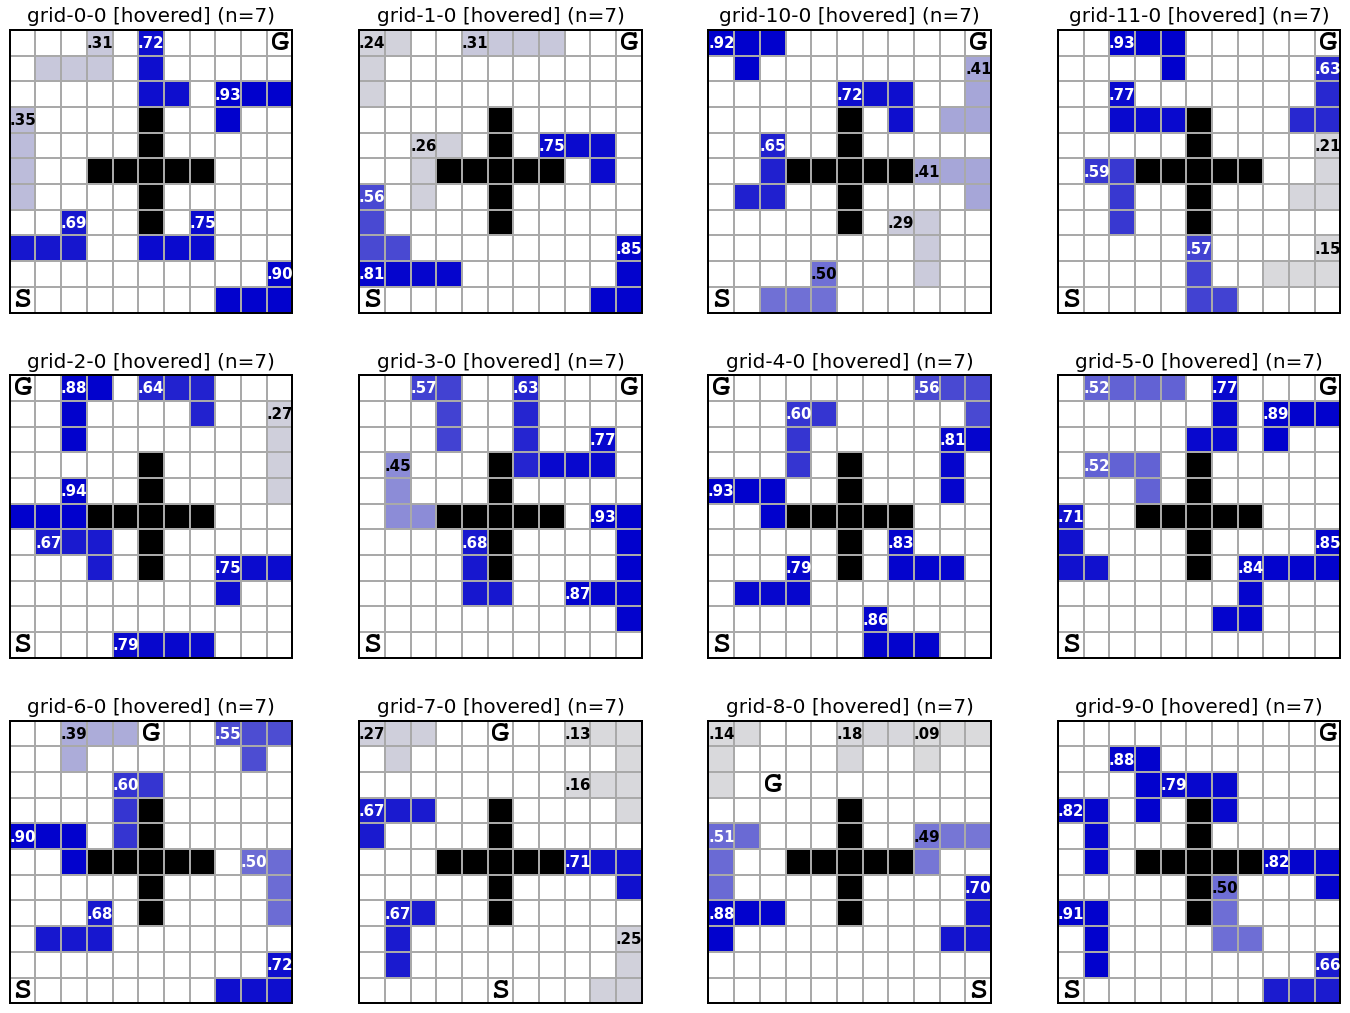

In [5]:
to_plot = hover_df.groupby(['grid', 'obstacle'])['hovered'].agg(['mean', 'sem', 'count']).reset_index()
nrows = 3
ncols = 4
mul=6
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*mul, nrows*mul))
axes = list(axes.flatten())
for grid, rows in to_plot.groupby('grid'):
    tile_array = basegrids[grid]
    values = dict(zip([str(o) for o in rows.obstacle.values], rows['mean'].fillna(0).values))
    ax = axes.pop(0)
    title = f"{grid} [hovered] (n={len(rows)})"
    plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=True, number_fontsize=15, number_format="f")

In [6]:
from vgc_project.modelinterface import create_modeling_interface
from vgc_project import utils

mods = create_modeling_interface(joblib_cache_location="../../experiments/_analysiscache")
model_preds = []
for _, (gn, obs) in hover_df[['grid', 'obstacle']].iterrows():
    model_preds.append(mods.predictions(tuple(basegrids[gn]), obs, seed=72193880))
    
hover_df = pd.concat([
    hover_df.reset_index(drop=True),
    pd.DataFrame(model_preds)
], axis=1)

to_zscore = [
    'vgc_weight',
    'value_mix_weight',
    'graph_based_hitcount', 'goal_dist',
    'start_dist', 'optpolicy_dist', 'walls_dist', 'center_dist',
    'bottleneck_dist', 'sr_occ',
    'log_traj_based_hitcount'
]
for col in to_zscore:
    hover_df[col+"_Z"] = utils.zscore(hover_df[col])

In [7]:
# check that all obstacles and grids show up
assert hover_df.groupby(['sessionId', 'grid'])['obstacle'].apply(lambda os: set(os) == set('0123456')).all()

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [10]:
hover_df[['log_hoverduration', 'vgc_weight_Z', 'value_mix_weight_Z', 'graph_based_hitcount_Z',
       'goal_dist_Z', 'start_dist_Z', 'optpolicy_dist_Z', 'walls_dist_Z',
       'center_dist_Z', 'bottleneck_dist_Z', 'sr_occ_Z',
       'log_traj_based_hitcount_Z']].corr()

,log_hoverduration,vgc_weight_Z,value_mix_weight_Z,graph_based_hitcount_Z,goal_dist_Z,start_dist_Z,optpolicy_dist_Z,walls_dist_Z,center_dist_Z,bottleneck_dist_Z,sr_occ_Z,log_traj_based_hitcount_Z
log_hoverduration,1.000000,0.142120,-0.037820,0.110252,-0.019824,0.086133,-0.114326,0.049060,0.059118,-0.136566,-0.035533,0.042843
vgc_weight_Z,0.142120,1.000000,0.295439,0.525942,0.004250,-0.114301,-0.362805,-0.458057,-0.439059,-0.287512,0.234089,0.491906
value_mix_weight_Z,-0.037820,0.295439,1.000000,-0.115398,0.077277,-0.188624,-0.066828,-0.079574,-0.070853,-0.107615,0.085703,-0.138583
graph_based_hitcount_Z,0.110252,0.525942,-0.115398,1.000000,0.028021,-0.140301,-0.231908,-0.385081,-0.382039,-0.179159,0.292067,0.746320
goal_dist_Z,-0.019824,0.004250,0.077277,0.028021,1.000000,-0.745234,0.007316,-0.038301,-0.037736,-0.163367,-0.002824,-0.006008
start_dist_Z,0.086133,-0.114301,-0.188624,-0.140301,-0.745234,1.000000,-0.026297,0.181668,0.183273,-0.050568,-0.237723,-0.154067
optpolicy_dist_Z,-0.114326,-0.362805,-0.066828,-0.231908,0.007316,-0.026297,1.000000,0.119600,0.119506,0.547109,-0.082450,-0.003078
walls_dist_Z,0.049060,-0.458057,-0.079574,-0.385081,-0.038301,0.181668,0.119600,1.000000,0.994602,0.258229,-0.452201,-0.554846
center_dist_Z,0.059118,-0.439059,-0.070853,-0.382039,-0.037736,0.183273,0.119506,0.994602,1.000000,0.262522,-0.465711,-0.544128
bottleneck_dist_Z,-0.136566,-0.287512,-0.107615,-0.179159,-0.163367,-0.050568,0.547109,0.258229,0.262522,1.000000,0.054958,-0.067102


In [11]:
%%R -i hover_df
full <- glmer(
    hovered ~ 
        (1 | sessionId) + (1 | grid) +
            vgc_weight_Z +
            log_traj_based_hitcount_Z + 
            graph_based_hitcount_Z +
            goal_dist_Z +
            start_dist_Z +
            walls_dist_Z +
            center_dist_Z +
            optpolicy_dist_Z +
            bottleneck_dist_Z +
            value_mix_weight_Z +
            sr_occ_Z
    ,
    control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=hover_df,
    family=binomial
)
print(anova(
    update(full, ~ . - vgc_weight_Z),
    full
))
summary(full)

Data: hover_df
Models:
update(full, ~. - vgc_weight_Z): hovered ~ (1 | sessionId) + (1 | grid) + log_traj_based_hitcount_Z + 
update(full, ~. - vgc_weight_Z):     graph_based_hitcount_Z + goal_dist_Z + start_dist_Z + walls_dist_Z + 
update(full, ~. - vgc_weight_Z):     center_dist_Z + optpolicy_dist_Z + bottleneck_dist_Z + value_mix_weight_Z + 
update(full, ~. - vgc_weight_Z):     sr_occ_Z
full: hovered ~ (1 | sessionId) + (1 | grid) + vgc_weight_Z + log_traj_based_hitcount_Z + 
full:     graph_based_hitcount_Z + goal_dist_Z + start_dist_Z + walls_dist_Z + 
full:     center_dist_Z + optpolicy_dist_Z + bottleneck_dist_Z + value_mix_weight_Z + 
full:     sr_occ_Z
                                Df   AIC   BIC  logLik deviance  Chisq Chi Df
update(full, ~. - vgc_weight_Z) 13 15317 15415 -7645.5    15291              
full                            14 15166 15271 -7568.8    15138 153.32      1
                                Pr(>Chisq)    
update(full, ~. - vgc_weight_Z)               
fu

In [12]:
%%R -i hover_df
full <- lmer(
    log_hoverduration ~ 
        (1 + round | sessionId) + (1 | grid) + 
            vgc_weight_Z +
            log_traj_based_hitcount_Z + 
            graph_based_hitcount_Z +
            goal_dist_Z +
            start_dist_Z +
            walls_dist_Z +
            center_dist_Z +
            optpolicy_dist_Z +
            bottleneck_dist_Z +
            value_mix_weight_Z +
            sr_occ_Z
    ,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=hover_df[!is.na(hover_df$log_hoverduration),],
    REML=F
)
print(anova(
    update(full, ~ . - vgc_weight_Z),
    full
))
summary(full)

Data: hover_df[!is.na(hover_df$log_hoverduration), ]
Models:
update(full, ~. - vgc_weight_Z): log_hoverduration ~ (1 + round | sessionId) + (1 | grid) + log_traj_based_hitcount_Z + 
update(full, ~. - vgc_weight_Z):     graph_based_hitcount_Z + goal_dist_Z + start_dist_Z + walls_dist_Z + 
update(full, ~. - vgc_weight_Z):     center_dist_Z + optpolicy_dist_Z + bottleneck_dist_Z + value_mix_weight_Z + 
update(full, ~. - vgc_weight_Z):     sr_occ_Z
full: log_hoverduration ~ (1 + round | sessionId) + (1 | grid) + vgc_weight_Z + 
full:     log_traj_based_hitcount_Z + graph_based_hitcount_Z + goal_dist_Z + 
full:     start_dist_Z + walls_dist_Z + center_dist_Z + optpolicy_dist_Z + 
full:     bottleneck_dist_Z + value_mix_weight_Z + sr_occ_Z
                                Df   AIC   BIC logLik deviance  Chisq Chi Df
update(full, ~. - vgc_weight_Z) 16 26464 26577 -13216    26432              
full                            17 26388 26509 -13177    26354 77.626      1
                         

# Individual trials

In [13]:
from scipy.signal import savgol_filter
from vgc_project import gridutils
from collections import defaultdict
def calc_velocity(m, nm, duration):
    dx = m[0] - nm[0]
    dy = m[1] - nm[1]
    return ((dx*dx + dy*dy)**.5)/(duration+.01)
def hoverdurations(hoverdata, only_obs=True):
    dur = defaultdict(int)
    for e in hoverdata:
        assert e['visible']
        if only_obs:
            if e['obstacle'] not in '0123456789':
                continue
        else:
            if e['obstacle'] == '.':
                continue
        dur[e['obstacle']] += e['exitTime'] - e['enterTime']
    dur['any_hovering'] = len(dur) > 0
    return dict(dur)
def plot_individual_trajectory(trialrow):
    c0, cf = np.array((51, 51, 255))/255, np.array((255, 153, 51))/255
    gridname = trialrow['grid']
    grid = basegrids[gridname]
    gw = GridWorld(grid)
    
    hoverdur = hoverdurations(trialrow['mouseHoverData'], only_obs=False)
    hoverdur = {k: np.log(v) for k, v in hoverdur.items()}
    fc = {f: v for f, v in hoverdur.items() if f in '0123456789'}
    fc = {f: (0, 0, 0, fc.get(f, 1.0)/(max(fc.values())*1.2)) for f in set('01234567') & set(''.join(basegrids[gridname]))}
    gwp = gw.plot(featurecolors={**fc, "#": 'k', "G": "green", "S": 'blue'}, figsize_multiplier=.7)
    
    state_traj = [t['state'] for t in trialrow['navigationData']] + [trialrow['navigationData'][-1]['nextstate'], ]
    trans = trialrow['transformation']
    state_traj = [gridutils.untransformState[trans](grid, s) for s in state_traj]
    gwp.plot_trajectory(state_traj, jitter_var=.2, linewidth=4, color='green', zorder=1004, linestyle='--')
    for s, ns in zip(state_traj[:-1], state_traj[1:]):
        if s == ns:
            gwp.ax.plot(s[0] + np.random.random(), s[1] + np.random.random(), 'go', mfc='none', markersize=12, mew=4, zorder=1004)
    
    mouse_moves = [(m['mouseX'], m['mouseY']) for m in trialrow['mouseMoveData']]
    mouse_moves = [gridutils.untransformContinuousXY[trans](grid, m) for m in mouse_moves]
    xs, ys = zip(*mouse_moves)
    w = np.linspace(0, 1, num=len(xs))
    c = (1 - w[:, None])*c0[None, :] + w[:, None]*cf[None, :]
    durations = [nm['time'] - m['time'] for m, nm in zip(trialrow['mouseMoveData'], trialrow['mouseMoveData'][1:])]
    moves_durations = list(zip(list(zip(mouse_moves, mouse_moves[1:])), durations))
    vs = 10/(np.clip(savgol_filter([0,] + [calc_velocity(m, nm, d) for (m, nm), d in moves_durations], 11, 2), .001, 100)**.5)
    gwp.ax.scatter(x=xs, y=ys, c=c, zorder=1000, alpha=.8, s=vs)
    for mi, (m, nm) in enumerate(zip(mouse_moves, mouse_moves[1:])):
        gwp.ax.plot([m[0], nm[0]], [m[1], nm[1]], color=c[mi], alpha=.8, lw=.5)
    gwp.ax.plot(xs[0], ys[0], marker="D", color=c0, zorder=1001, markersize=25, mec='w', mew=3)
    gwp.ax.plot(xs[-1], ys[-1], marker="*", color=cf, zorder=1001, markersize=45, mec='k', mew=3)
    for f, locs in gw.feature_locations.items():
        logdur = hoverdur.get(f, 0.0)
        if f not in '0123456789#GS':
            continue
        gwp.annotate(locs[0], text=f"{logdur:.1f}", fontsize=20, color='red', zorder=1003, fontweight='bold')

266 2.0 vNhKEJvGzC


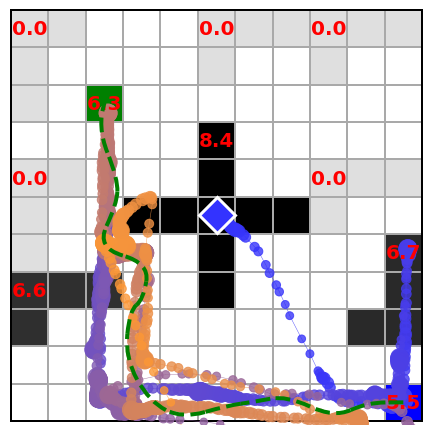

In [14]:
trialrow = nav_trials.sample(axis=0).iloc[0]
# trialrow = nav_trials.iloc[216]
print(trialrow.name, trialrow['round'], trialrow.sessionId)
plot_individual_trajectory(trialrow)